In [17]:
#Imports 
import pandas as pd
import numpy as np

In [18]:
#read dataset as df
df = pd.read_excel("../data/NTCMRC_all.xlsx")
df.head(5)

,sid,P_Number,birth,data_exam,CMRC_id,sex,age,data_year,year_come,height_y,...,"腎結節 ( yes=1, no=0)","左腎 (無:0, 單一:1,多發:2).3",公分.23,"右腎 (無:0, 單一:1,多發:2).3",公分.24,脾臟 (0:正常;1:脾臟腫大；2脾臟切除),spleen long axis (cm),spleen short axis (cm),脾面積(大於20CM=脾腫大),other
0,M11A011,M11A011,391127,20221122,R8M080Y5005M5,0,71,2022,2,145.2,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,20221119122,P111782,410428,20221119,E42018P21120K8045,0,70,2022,3,153.5,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,20221119121,P111781,401120,20221119,H62016G10710R5042,0,70,2022,5,147.5,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,20221119120,P111780,430325,20221119,U32016A80710B9013,0,68,2022,4,148,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,20221119119,P111779,390220,20221119,A72018S91120Z2060,1,72,2022,3,157,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [19]:
import sys
sys.path.append("../")
from utilities import utils

In [20]:
import os
print(os.getcwd())

/Users/sizhechen/Desktop/git/fatty-liver-project/src/features


In [72]:
# Create a copy of df as df1
df1 = df.copy()

# Replace '\\N' with NaN
df1 = df1.replace('\\N', np.nan)

# Specify the columns to be converted to FLOAT
columns_to_convert1 = ['BMI', 'Triglyceride_y', 'gamgt', 'waist_y', 'mst', 'egfrn', 'Estimated_GFR_x', 'Alb_Cre_ratio', 'HOMA_IR', 'HS_CRP', \
                       'LDL_C_direct', 'LDL_C_HDL_C', 'Adiponectin', 'Leptin', 'Uric_Acid','Insulin', 'ALT_GPT']

# Specify the columns to be converted to INT
columns_to_convert2 = ['脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)', 'smoke', 'smoke_q', \
                       'sex', 'w', 'coffee', 'betel']

# Convert the specified columns to float and fill missing/unconvertible values with NaN
for column in columns_to_convert1:
    df1[column] = pd.to_numeric(df1[column], errors='coerce')

# Convert the specified columns to int and fill missing/unconvertible values with NaN
for column in columns_to_convert2:
    df1[column] = pd.to_numeric(df1[column], errors='coerce').astype(pd.Int64Dtype())

# Calculate FLI using the formula and defined as df2
df2 = df1.copy()
df2['FLI'] = (np.exp(0.953 * np.log(df2['Triglyceride_y']) + 0.139 * df2['BMI'] + 0.718 * np.log(df2['gamgt']) \
     + 0.053 * df2['waist_y'] - 15.745)) / (1 + np.exp(0.953 * np.log(df2['Triglyceride_y']) \
    + 0.139 * df2['BMI'] + 0.718 * np.log(df2['gamgt']) + 0.053 * df2['waist_y'] - 15.745)) * 100

# Derive FL_echo based on ultrasound results column
df2['FL_echo'] = df2['脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)']
df2['FL_echo'] = df2['FL_echo'].replace('<NA>', np.nan)
df2['fl_status'] = df2.apply(utils.derive_fl_status, axis=1)

#Derive homa_ir_check, hs_crp_check, and mst_total to determine MAFLD risk factors
df2['homa_ir_check'] = df2['HOMA_IR'].apply(lambda x: 1 if x >= 2.5 else 0)
df2['hs_crp_check'] = df2['HS_CRP'].apply(lambda x: 1 if x > 2 else 0)
df2['mst_total'] = df2[['w', 'hyper', 'HDL', 'fg', 'trig', 'homa_ir_check', 'hs_crp_check']].sum(axis=1)


df3 = utils.derive_CKD(utils.derive_MAFLD(df2))

# Derive FL_group_list, 对CMRC_id分组并计算每个病人的FL_Check的唯一值
grouped = df2.groupby('CMRC_id')['fl_status'].unique()
df2['fl_group_list'] = df2.groupby('CMRC_id')['fl_status'].transform(lambda x: [x.unique().tolist()] * len(x))

#assign patient valid value
df4 = utils.assign_patient_fl_validity(df3)

# Deal with values with both string and num values: HBsAg_x, Anti_HCV_x, (values eg. 陰性    0.351)
# extract numeric values for these cols and rename that as  *_num
columns_to_extract = ['HBsAg_x', 'Anti_HCV_x']
df5 = df4.copy()
for column in columns_to_extract:
    new_column_name = column + '_num'
    df5[new_column_name] = df5[column].apply(utils.extract_numeric_value)

# Sliding window implementation, ie. use previous 2 years record to predict the 3 year MAFLD status
df6 = utils.sliding_window_data(df5, input_window_size=2, target_window_size=1)

# Filter available data that can be applied to models
df7 = df6[(df6['t3_MAFLD'] != -1)]

# Drop ID relevant cols in the dataset
columns_to_drop = ['CMRC_id', 't1_CMRC_id', 't2_CMRC_id', 't1_sid', 't2_sid', 't1_P_Number','t2_P_Number']
df8 = df7.drop(columns=columns_to_drop)

#Select key columns for conventional machine learning models
columns = ["sex", "age", "waist_y", "Glucose_AC_y", "Triglyceride_y", "HDL_C_y", "AST_GOT", "ALT_GPT", \
          "gamgt", "Insulin", "T_Cholesterol", "LDL_C_direct", "VLDL_C", "Non_HDL_C", "T_CHOL_HDL_C", \
          "LDL_C_HDL_C", "HS_CRP", "Hb_A1c", "Uric_Acid", "HBsAg_x", "Anti_HCV_x", "HOMA_IR", "Adiponectin", \
           "Leptin", "TotalVitaminD", "smoke", "smoke_q", "coffee", "betel", "BMI", "DM_determine", "w", "hyper", \
           "fg", "HDL", "trig", "sarcf", "ms2", "MNA", "AUDIT", "HBV_", "HCV_", "MAFLD", "CKD", \
           'HBsAg_x_num', 'Anti_HCV_x_num']
prefixes = ["t1_", "t2_"]
renamed_columns = utils.add_prefix(columns, prefixes)

df9 = df8[renamed_columns]
df9['t3_MAFLD'] = df8['t3_MAFLD']

# drop these cols as those been derived for numeric cols, remain alias *_num,
cols_to_drop_only_MAFLD = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x', 't1_MAFLD', 't2_MAFLD']
cols_to_drop_fli_related = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x', 't1_MAFLD', 't2_MAFLD', \
                            't1_Triglyceride_y', 't1_BMI', 't1_gamgt', 't1_waist_y', 't1_gamgt', 't1_w', \
                            't2_Triglyceride_y', 't2_BMI', 't2_gamgt', 't2_waist_y', 't2_gamgt', 't2_w']
df9_a = df9.drop(cols_to_drop_only_MAFLD, axis=1)

#FLI related cols: Triglyceride_y, BMI, gamgt, waist_y, gamgt
df9_b = df9.drop(cols_to_drop_fli_related, axis=1)

df9_b.head()

/Users/sizhechen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-72-43b5813798ac>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['t3_MAFLD'] = df8['t3_MAFLD']


,t1_sex,t1_age,t1_Glucose_AC_y,t1_HDL_C_y,t1_AST_GOT,t1_ALT_GPT,t1_Insulin,t1_T_Cholesterol,t1_LDL_C_direct,t1_VLDL_C,...,t2_sarcf,t2_ms2,t2_MNA,t2_AUDIT,t2_HBV_,t2_HCV_,t2_CKD,t2_HBsAg_x_num,t2_Anti_HCV_x_num,t3_MAFLD
0,0,59,101.0,56.4,21.0,19.0,9.18,315.0,196.5,53.0,...,NaN,1,NaN,1.0,NaN,NaN,1,NaN,NaN,0
1,0,60,104.0,55.8,15.0,18.0,5.86,312.0,199.0,51.0,...,NaN,1,NaN,0.0,0.0,0.0,2,0.48,0.030,0
2,0,62,103.0,60.7,18.0,22.0,4.56,213.0,115.0,38.0,...,NaN,1,NaN,0.0,NaN,NaN,2,NaN,NaN,1
3,0,63,111.0,83.0,27.0,30.0,6.30,267.0,157.6,33.0,...,NaN,1,NaN,0.0,0.0,0.0,2,0.33,0.036,0
4,0,58,99.0,60.4,23.0,17.0,3.75,198.0,117.8,15.0,...,NaN,0,NaN,1.0,NaN,NaN,2,NaN,NaN,0


In [73]:
df9_b_female = df9_b[(df9_b['t1_sex'] == 0)]
df9_b_male = df9_b[(df9_b['t1_sex'] == 1)]

In [74]:
df6['t3_MAFLD'].value_counts()

t3_MAFLD
 0    7614
 1    2044
-1      66
Name: count, dtype: int64

In [75]:
df9_b['t3_MAFLD'].value_counts()

t3_MAFLD
0    7614
1    2044
Name: count, dtype: int64

In [76]:
df9_b.shape[0]

9658

In [77]:
df3['MAFLD'].value_counts()

MAFLD
 0    17211
 1     5002
-1      621
Name: count, dtype: int64

In [45]:
df9_b['t2_MNA'].value_counts(dropna=False)

t2_MNA
NaN     7939
23.5     176
24.5     170
23.0     163
24.0     161
25.0     151
22.5     122
22.0     117
21.5      93
20.5      86
21.0      82
25.5      81
26.0      72
19.5      49
20.0      45
19.0      30
18.5      13
18.0      11
17.5      10
16.0      10
17.0      10
27.0       9
26.5       8
16.5       7
12.5       5
14.0       4
15.0       3
11.0       3
15.5       3
14.5       3
5.0        3
10.0       2
8.5        2
13.5       2
7.0        2
13.0       2
11.5       1
12.0       1
3.0        1
6.5        1
27.5       1
9.5        1
4.0        1
6.0        1
10.5       1
Name: count, dtype: int64

In [47]:
# Modeling - baseline model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [82]:
# start modeling preparation
# split categorical and numerical variables,

df9_b.drop('t2_sex', axis=1, inplace=True)
features = df9_b.columns.drop(['t3_MAFLD'])

categorical_features = ['t1_sex', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD', \
                        't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']
numeric_features = df9_b.columns.drop(categorical_features).drop(['t3_MAFLD'])
X_categorical = df9_b[categorical_features]
X_numeric = df9_b[numeric_features]
y = df9_b['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

X_conbined shape:  (9658, 102)
y shape:  (9658,)


In [83]:
# train test split, seed=2023
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Baseline Logistic model(all important factors without FLI related) AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Baseline Random Forest(all important factors without FLI related) AUC score: ", auc_rf)

Baseline Logistic model(all important factors without FLI related) AUC score:  0.7921319345159048
Baseline Random Forest(all important factors without FLI related) AUC score:  0.7907269480501133


In [50]:
from sklearn.metrics import f1_score, confusion_matrix

# Calculate F1 score for Logistic Regression model
f1_log = f1_score(y_test, predictions_log)
print("Baseline Logistic model F1 score: ", f1_log)

# Calculate F1 score for Random Forest model
f1_rf = f1_score(y_test, predictions_rf)
print("Baseline Random Forest F1 score: ", f1_rf)


Baseline Logistic model F1 score:  0.4180418041804181
Baseline Random Forest F1 score:  0.39348079161816063


/Users/sizhechen/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/sizhechen/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

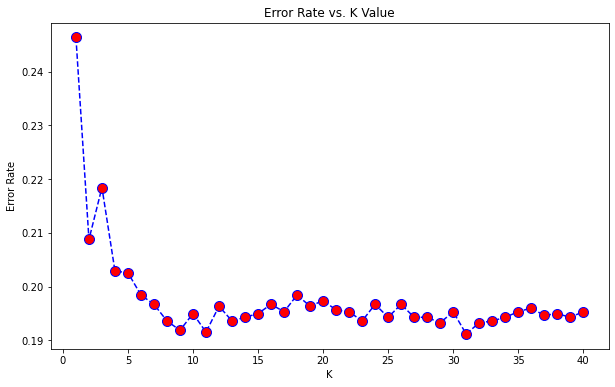

In [51]:
# KNN Model
# step1: Find K for KNN model
def plot_knn_error_rate(X_train, y_train, X_test, y_test, max_k=40):
    error_rate = []

    # Calculate error rate for different K values
    for i in range(1, max_k+1):
        knn_model = KNeighborsClassifier(n_neighbors=i)
        knn_model.fit(X_train, y_train)
        pred_i = knn_model.predict(X_test)
        error_rate.append(np.mean(pred_i != y_test))

    # Plot the error rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k+1), error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.show()

plot_knn_error_rate(X_train, y_train, X_test, y_test)

In [52]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

def svm_model(X_train, y_train, X_test, y_test):
    svm_model = SVC(probability=True)
    svm_model.fit(X_train, y_train)

    # Evaluation
    predictions_svm = svm_model.predict(X_test)
    probabilities_svm = svm_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

    # Calculate metrics
    auc_svm = roc_auc_score(y_test, probabilities_svm)
    f1_svm = f1_score(y_test, predictions_svm)

    return {
        "auc": auc_svm,
        "f1_score": f1_svm,
        "classification_report": classification_report(y_test, predictions_svm)
    }

def kNearestNeighbor_model(X_train, y_train, X_test, y_test, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    predictions = knn.predict(X_test)
    probabilities_knn = knn.predict_proba(X_test)  # Predict probabilities for each class
    probabilities_positive = probabilities_knn[:, 1]  # Extract probabilities for the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    f1_knn = f1_score(y_test, predictions)
    classification = classification_report(y_test, predictions)
    auc = roc_auc_score(y_test, probabilities_positive)

    return {
        "accuracy": accuracy,
        "f1_score": f1_knn,
        "classification_report": classification,
        "auc": auc
    }


In [53]:
print("KNN(N=9) Model AUC:", kNearestNeighbor_model(X_train, y_train, X_test, y_test, n_neighbors=9)["auc"])
print("SVM Model AUC:", svm_model(X_train, y_train, X_test, y_test)["auc"])
print("KNN(N=9) Model F1 score:", kNearestNeighbor_model(X_train, y_train, X_test, y_test, n_neighbors=9)["f1_score"])
print("SVM Model F1 score:", svm_model(X_train, y_train, X_test, y_test)["f1_score"])

/Users/sizhechen/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN(N=9) Model AUC: 0.7393209726546826
SVM Model AUC: 0.7550700303460123


/Users/sizhechen/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN(N=9) Model F1 score: 0.3579676674364896
SVM Model F1 score: 0.3436341161928307


Sparate for sex to check predictive power

In [63]:
df9_b.shape

(9658, 77)

In [64]:
df9_b_male.shape

(3185, 77)

In [65]:
df9_b_female.shape

(6473, 77)

In [78]:
# Modeling for df_9b_female
# start modeling preparation for female
# split categorical and numerical variables,

df9_b_female.drop(['t1_sex','t2_sex'], axis=1, inplace=True)
features = df9_b_female.columns.drop(['t3_MAFLD'])

categorical_features = ['t1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD', \
                        't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']
numeric_features = df9_b_female.columns.drop(categorical_features).drop(['t3_MAFLD'])
X_categorical = df9_b_female[categorical_features]
X_numeric = df9_b_female[numeric_features]
y = df9_b_female['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

<ipython-input-78-142f186e6f62>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9_b_female.drop(['t1_sex','t2_sex'], axis=1, inplace=True)


X_conbined shape:  (6473, 100)
y shape:  (6473,)


In [79]:
# train test split, seed=2023
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Baseline Logistic model(Female Only) AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Baseline Random Forest(Female Only) AUC score: ", auc_rf)

Baseline Logistic model(Female Only) AUC score:  0.7849674109493519
Baseline Random Forest(Female Only) AUC score:  0.765045752750146


In [80]:
# Modeling for df9_b_male
# start modeling preparation for female
# split categorical and numerical variables,

df9_b_male.drop(['t1_sex','t2_sex'], axis=1, inplace=True)
features = df9_b_male.columns.drop(['t3_MAFLD'])

categorical_features = ['t1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD', \
                        't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']
numeric_features = df9_b_male.columns.drop(categorical_features).drop(['t3_MAFLD'])
X_categorical = df9_b_male[categorical_features]
X_numeric = df9_b_male[numeric_features]
y = df9_b_male['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

X_conbined shape:  (3185, 100)
y shape:  (3185,)


<ipython-input-80-77bfb100d104>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9_b_male.drop(['t1_sex','t2_sex'], axis=1, inplace=True)


In [81]:
# train test split, seed=2023
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Baseline Logistic model(all important factors without FLI related) AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Baseline Random Forest(all important factors without FLI related) AUC score: ", auc_rf)

Baseline Logistic model(all important factors without FLI related) AUC score:  0.7780901936574965
Baseline Random Forest(all important factors without FLI related) AUC score:  0.7980188106638723


In [84]:
df9_b_male['t3_MAFLD'].value_counts()

t3_MAFLD
0    2257
1     928
Name: count, dtype: int64

In [85]:
df9_b_female['t3_MAFLD'].value_counts()

t3_MAFLD
0    5357
1    1116
Name: count, dtype: int64

Separate for T2DM

In [ ]:
# Check data sparsity

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
# imputer = SimpleImputer(strategy='median')
# X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed1 = pd.DataFrame(X_numeric_scaled, columns=X_numeric.columns)
X_numeric_scaled_imputed1.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined1 = pd.concat([X_numeric_scaled_imputed1, X_categorical_encoded], axis=1)

missing_data = X_combined1.isnull().sum()
sparsity = missing_data.sum() / (X_combined1.shape[0] * X_combined1.shape[1])
print("Data Sparsity:", sparsity)

missing_data = df9_b.isnull().sum()
sparsity = missing_data.sum() / (df9_b.shape[0] * df9_b.shape[1])
print("df9b Data Sparsity:", sparsity)

Data Sparsity: 0.10697115872648501
df9b Data Sparsity: 0.14624091290558142


In [ ]:
# 计算每个特征的空值比例
missing_values_ratio = (X_combined1.isnull().sum() / len(X_combined1)) * 100

# 根据空值比例降序排序特征
sorted_features = missing_values_ratio.sort_values(ascending=False)

# 打印空值比例最高的前几个特征
top_n = 10  # 指定要显示的特征数量
print("Top", top_n, "features with the highest missing value ratio:")
print(sorted_features.head(top_n))


Top 10 features with the highest missing value ratio:
t1_MNA            98.622903
t1_sarcf          98.581487
t2_Adiponectin    87.854628
t2_Leptin         85.763098
t2_MNA            82.201284
t2_sarcf          82.087389
t1_Adiponectin    64.454338
t1_Leptin         63.657072
t2_HBV_           48.353696
t2_HCV_           47.711742
dtype: float64


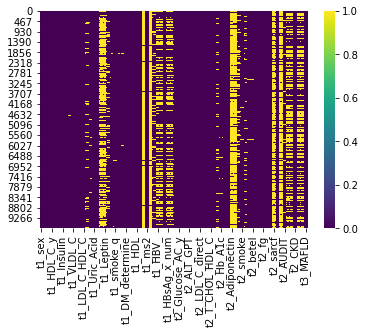

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(df9_b.isnull(), cmap="viridis")
plt.show()

Try ANN

Analysis 1

In [ ]:
#Analysis 1: The impact of interval years
# Start with df9_b, dataset does not contains BMI, etc variables
# Check t1->t3
def select_columns(df, prefix, additional_column=None):
    selected_columns = [col for col in df.columns if col.startswith(prefix)]
    if additional_column is not None:
        selected_columns.append(additional_column)
    return df[selected_columns]

df10_b_t1 = select_columns(df9_b, 't1_', 't3_MAFLD')
df10_b_t1.head(1)

,t1_sex,t1_age,t1_Glucose_AC_y,t1_HDL_C_y,t1_AST_GOT,t1_ALT_GPT,t1_Insulin,t1_T_Cholesterol,t1_LDL_C_direct,t1_VLDL_C,...,t1_sarcf,t1_ms2,t1_MNA,t1_AUDIT,t1_HBV_,t1_HCV_,t1_CKD,t1_HBsAg_x_num,t1_Anti_HCV_x_num,t3_MAFLD
0,0,59,101.0,56.4,21.0,19.0,9.18,315.0,196.5,53.0,...,NaN,1,NaN,NaN,0.0,0.0,2,0.44,0.04,0


In [ ]:
# start modeling preparation
# split categorical and numerical variables,
features = df10_b_t1.columns.drop(['t3_MAFLD'])

categorical_features = ['t1_sex', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD']

numeric_features = df10_b_t1.columns.drop(categorical_features).drop(['t3_MAFLD'])
X_categorical = df10_b_t1[categorical_features]
X_numeric = df10_b_t1[numeric_features]
y = df10_b_t1['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

X_conbined shape:  (9658, 52)
y shape:  (9658,)


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)
print("Start train test split with Random Seed = 2023")

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Logistic model(all important factors without FLI related) for t1 predict t3 AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Random Forest(all important factors without FLI related) for t1 predict t3 AUC score: ", auc_rf)

Start train test split with Random Seed = 2023
Logistic model(all important factors without FLI related) for t1 predict t3 AUC score:  0.7779443260868336
Random Forest(all important factors without FLI related) for t1 predict t3 AUC score:  0.7916205166168436


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=713)
print("Start train test split with Random Seed = 713")

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Logistic model(all important factors without FLI related) for t1 predict t3 AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Random Forest(all important factors without FLI related) for t1 predict t3 AUC score: ", auc_rf)

Start train test split with Random Seed = 713
Logistic model(all important factors without FLI related) for t1 predict t3 AUC score:  0.7889919355130798
Random Forest(all important factors without FLI related) for t1 predict t3 AUC score:  0.7903074037828405


In [ ]:
# Check t2 ->t3
df10_b_t2 = select_columns(df9_b, 't2_', 't3_MAFLD')
df10_b_t2['t1_sex'] = df9_b['t1_sex']
df10_b_t2.head(1)

<ipython-input-85-6ca1ec3c7adc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10_b_t2['t1_sex'] = df9_b['t1_sex']


,t2_age,t2_Glucose_AC_y,t2_HDL_C_y,t2_AST_GOT,t2_ALT_GPT,t2_Insulin,t2_T_Cholesterol,t2_LDL_C_direct,t2_VLDL_C,t2_Non_HDL_C,...,t2_ms2,t2_MNA,t2_AUDIT,t2_HBV_,t2_HCV_,t2_CKD,t2_HBsAg_x_num,t2_Anti_HCV_x_num,t3_MAFLD,t1_sex
0,60,104.0,55.8,15.0,18.0,5.86,312.0,199.0,51.0,256.0,...,1,NaN,1.0,NaN,NaN,1,NaN,NaN,0,0


In [ ]:
# start modeling preparation for t2
# split categorical and numerical variables,
features = df10_b_t2.columns.drop(['t3_MAFLD'])

categorical_features = ['t1_sex', 't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']
numeric_features = df10_b_t2.columns.drop(categorical_features).drop(['t3_MAFLD'])
X_categorical = df10_b_t2[categorical_features]
X_numeric = df10_b_t2[numeric_features]
y = df10_b_t2['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

X_conbined shape:  (9658, 52)
y shape:  (9658,)


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)
print("Start train test split with Random Seed = 2023")

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)

print("Logistic model(all important factors without FLI related) for t2 predict t3 AUC score: ",auc_log)
print("Random Forest(all important factors without FLI related) for t2 predict t3 AUC score: ", auc_rf)

Start train test split with Random Seed = 2023
Logistic model(all important factors without FLI related) for t2 predict t3 AUC score:  0.7727983600721071
Random Forest(all important factors without FLI related) for t2 predict t3 AUC score:  0.7744834255392492


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=713)
print("Start train test split with Random Seed = 713")

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Logistic model(all important factors without FLI related) for t2 predict t3 AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Random Forest(all important factors without FLI related) for t1 predict t3 AUC score: ", auc_rf)

Start train test split with Random Seed = 713
Logistic model(all important factors without FLI related) for t2 predict t3 AUC score:  0.787627209620883
Random Forest(all important factors without FLI related) for t1 predict t3 AUC score:  0.7844001109745259


Analysis 2

In [ ]:
# Analysis 2: the impact of survey data
# Feature selection - added survey data then modeling

columns = ["sex", "age", "waist_y", "Glucose_AC_y", "Triglyceride_y", "HDL_C_y", "AST_GOT", "ALT_GPT", \
          "gamgt", "Insulin", "T_Cholesterol", "LDL_C_direct", "VLDL_C", "Non_HDL_C", "T_CHOL_HDL_C", \
          "LDL_C_HDL_C", "HS_CRP", "Hb_A1c", "Uric_Acid", \
        #   "HBsAg_x", "Anti_HCV_x", \
          "HOMA_IR", "Adiponectin", \
           "Leptin", "TotalVitaminD", \
          #  "smoke", "smoke_q", "coffee", "betel",
           "BMI", "DM_determine", "w", "hyper", \
           "fg", "HDL", "trig", "sarcf", "ms2", "MNA", "AUDIT", "HBV_", "HCV_", "MAFLD", "CKD", \
           'HBsAg_x_num', 'Anti_HCV_x_num']

survey_data =['smoke', 's_smoke', 'smoke_t', 'smoke_q', 'smoke_qt1', 'smoke_qt2', 'smoke_f', 'smoke_n', 'smoke_second', \
           'tea', 'tea_c', 'tea_1', 'tea_t', 'tea_q', 'tea_f', 'tea_v', 'coffee', 'coffee_c', 'coffee_t', 'coffee_q', 'coffee_f', 'coffee_v', \
           'betel', 's_betel', 'betel_clt1', 'betel_clt2', 'betel_clt3', 'betel_clt4', 'betel_clt5', 'betel_clt6', 'betel_o', 'betel_t', 'betel_q', 'betel_f', 'betel_n', \
           'activity_t', 'carryh', 'sport', 'sport_1', 'sport_d', 'sport_t', 'cardio', 'hypertension', 'Dysrhythmia', 'ap', 'ami', 'Hyperlipidemia', 'HF', 'f_cardio', \
           'f_hyper', 'f_dys', 'f_ap', 'f_ami', 'f_lipid', 'f_hf', 'm_cardio', 'm_hyper', 'm_dys', 'm_ap', 'm_ami', 'm_lipid', 'm_hf', 'bs_cardio', 'bs_hyper', 'bs_hyper_1', \
           'bs_dys', 'bs_dys_1', 'bs_ap', 'bs_ap1', 'bs_ami', 'bs_ami_1', 'bs_lipid', 'bs_lipid_1', 'bs_hf', 'bs_hf_1', \
           'chi_cardio', 'chi_hyper', 'chi_dys', 'chi_ap', 'chi_ami', 'chi_lipid', 'chi_hf', \
           'endocrine', 'diabetes', 'Thyroid', 'f_dm', 'f_Thyroid', 'm_dm', 'm_Thyroid', 'bs_dm', 'bs_dm_1', 'bs_Thyroid', 'bs_Thyroid_1', \
           'chi_dm', 'chi_Thyroid', 'pepticulcer', 'gastritis', 'hbv', 'hcv', 'hepatitis_o', 'FLD', 'fibrosis', 'Cirrhosis', 'Polyposis', 'ibs', \
           'f_pud', 'f_hbv', 'f_hcv', 'f_liver', 'f_fld', 'f_f', 'f_lc', 'f_polyp', 'f_ibs', 'm_pud', 'm_hbv', 'm_hcv', 'm_liver', 'm_fld', 'm_f', 'm_lc', 'm_polyp', 'm_ibs', \
           'bs_pud', 'bs_pud_1', 'bs_hbv', 'bs_hbv_1', 'bs_hcv', 'bs_hcv_1', 'bs_liver', 'bs_fld', 'bs_fld_1', 'bs_f', 'bs_f_1', 'bs_lc', 'bs_lc_1', \
           'bs_polyp', 'bs_polyp_1', 'bs_ibs', 'bs_ibs_1', 'chi_pud', 'chi_hbv', 'chi_hcv', 'chi_liver', 'chi_fld', 'chi_f', 'chi_lc', 'chi_polyp', 'chi_ibs', \
           'respiratory', 'tb', 'Asthma', 'apnea', 'copd', 'f_resp', 'f_Asthma', 'f_apnea', 'f_copd', 'm_resp', 'm_Asthma', 'm_apnea', 'm_copd', \
           'bs_resp', 'bs_Asthma', 'bs_Asthma_1', 'bs_apnea', 'bs_apnea_1', 'bs_copd', 'bs_copd_1', 'chi_resp', 'chi_Asthma', 'chi_apnea', 'chi_copd', \
           'anemia', 'Hemophilia', 'f_anemia', 'f_h', 'm_anemia', 'm_h', 'bs_anemia', 'bs_anemia_1', 'bs_h', 'bs_h_1', 'chi_anemia', 'chi_h', \
           'stroke', 'brainbleed', 'head_injury', 'epilepsy', 'Parkinsons', 'dementia', 'Huntingtons', 'f_stroke', 'f_hi', 'f_brainbleed', 'f_epilep', 'f_pd', 'f_demen', 'f_hd', \
           'm_stroke', 'm_hi', 'm_brainbleed', 'm_epilep', 'm_pd', 'm_demen', 'm_hd', 'bs_stroke', 'bs_stroke_1', 'bs_hi', 'bs_hi_1', 'bs_brainbleed', 'bs_brainbleed_1', 'bs_epilep', \
           'bs_epilep_1', 'bs_pd', 'bs_pd_1', 'bs_demen', 'bs_demen_1', 'bs_hd', 'bs_hd_1', 'chi_stroke', 'chi_hi', 'chi_brainbleed', 'chi_epilep', 'chi_pd', 'chi_demen', 'chi_hd', \
           'insomnia', 'Depression', 'mdd_dx', 'mental', 'f_mdd', 'f_mdd_dx', 'f_mental', 'm_mdd', 'm_mdd_dx', 'm_mental', 'bs_mdd', 'bs_mdd_1', 'bs_mdd_dx', 'bs_mental', 'chi_mdd', \
           'chi_mdd_dx', 'chi_mental', 're_1', 'ckd', 'dialysis', 'gout', 'stone', 'bpn', 'f_re', 'f_ckd', 'f_dialysis', 'f_stone', 'f_bpn', 'm_re', 'm_ckd', 'm_dialysis', 'm_stone', \
           'm_bpn', 'bs_re', 'bs_ckd', 'bs_ckd_1', 'bs_dialysis', 'bs_dialysis_1', 'bs_stone', 'bs_stone_1', 'bs_bpn', 'bs_bpn_1', 'chi_re', 'chi_ckd', 'chi_dialysis', 'chi_stone', 'chi_bpn', \
           'cataract', 'glau', 'retina', 'sicca', 'f_cata', 'f_glau', 'f_retina', 'f_sicca', 'm_cata', 'm_glau', 'm_retina', 'm_sicca', 'bs_cata', 'bs_cata_1', 'bs_glau', 'bs_glau_1', 'bs_retina', \
           'bs_retina_1', 'bs_sicca', 'bs_sicca_1', 'chi_cata', 'chi_glau', 'chi_retina', 'chi_sicca', 'cancer', 'cancer_1', 'cantime', 'cancer_mi', 'lungcan', 'breastcna', 'colican', 'gastrican', \
           'livercan', 'cancer_o', 'f_can', 'f_can_1', 'f_canmi', 'f_lung', 'f_breast', 'f_coli', 'f_gastric', 'f_liver_c', 'f_can_o', 'm_can', 'm_can_1', 'm_canmi', 'm_lung', 'm_breast', 'm_coli', \
           'm_gastric', 'm_liver_c', 'm_can_o', 'bs_can', 'bs_can_1', 'bs_canmi', 'bs_lung', 'bs_lung_1', 'bs_breast', 'bs_breast_1', 'bs_coli', 'bs_coli_1', 'bs_gastric', 'bs_gastric_1', 'bs_liver_c', \
           'bs_liver_c_1', 'bs_can_o', 'chi_can', 'chi_can_1', 'chi_canmi', 'chi_lung', 'chi_breast', 'chi_coli', 'chi_gastric', 'chi_liver_c', 'chi_can_o', 'ndisease', 'fn', 'mn', 'bsn', 'chin', 'UNKNOWN', \
           'funknown', 'munknown', 'bsunknown', 'chiunknown', 'autoimmu', 'dis_o', 'f_dis_o', 'f_disable', 'm_dis_o', 'm_disable', 'bs_dis_o', 'bs_disable', 'chi_dis_o', 'chi_disable', 'Syr_drug', 'Hypnotic', \
           'drug', 'drug_w', 'drug_yr', 'drug_diag', 'drug_cont', 'hyper_drug', 'hyper_drugn', 'hyper_druga', 'hyper_confir', 'hyper_cont', 'dm_drug', 'dm_w', 'dm_yr', 'dm_diag', 'dm_cont', 'hor_drug', 'hor_w', \
           'hor_yr', 'hor_diag', 'hor_diag1', 'hor_cont', 'lipiddrug', 'lipidw', 'lipidyr', 'lipiddiag', 'lipiddiag1', 'lipidcont', 'supply', 'gasdrug', 'cmed', 'hf_none', 'hf_vit', 'hf_wgl', 'hf_foil', 'hf_ca', \
           'hf_p', 'hf_p1', 'hf_p2', 'hf_chic', 'hf_clam', 'hf_e', 'hf_lutein', 'hf_collagen', 'hf_other', 'hf_fmed', 'hf_unknown', 'hf_1', \
           'plastic_1', 'plastic_2', 'plastic_3', 'plastic_4', 'plastic_5', 'plastic_6', 'plastic_7', 'BI_1', 'BI_2', 'BI_3', \
           'SF36_1', 'SF36_2', 'sf36_3_a', 'sf36_3_b', 'sf36_3_c', 'sf36_3_d', 'sf36_3_e', 'sf36_3_f', 'sf36_3_g', 'sf36_3_h', 'sf36_3_i',\
           'sf36_3_j', 'sf36_4_a', 'sf36_4_b', 'sf36_4_c', 'sf36_4_d', 'sf36_5_a', 'sf36_5_b', 'sf36_5_c', 'sf36_6', 'sf36_7', 'sf36_8', 'sf36_9_a', 'sf36_9_b', \
           'sf36_9_c', 'sf36_9_d', 'sf36_9_e', 'sf36_9_f', 'sf36_9_g', 'sf36_9_h', 'sf36_9_i', 'sf36_10', 'sf36_11_a', 'sf36_11_b', 'sf36_11_c', 'sf36_11_d', \
           'check5', 'beda', 'bedb', 'bedt', 'waketa', 'waketb', 'sleepta', 'sleeptb', 'sleep1', 'sleep2', 'sleep3', 'sleep4', 'sleep5', 'sleep6', 'sleep7', 'sleep8', 'sleep9', 'sleep10', 'sleep10a', \
           'sleep11', 'sleep11v3', 'sleep12', 'sleep12v3', 'sleep13', 'sleep13v3', 'sleep14', 'sleep14v3', 'sleep15', 'check6', 'hads_1', 'hads_2', 'hads_3', 'hads_4', 'hads_5', 'hads_6', 'hads_7', 'hads_8', \
           'hads_9', 'hads_10', 'hads_11', 'hads_12', 'hads_13', 'hads_14', 'check7', 'uls8_1', 'uls8_2', 'uls8_3', 'uls8_4', 'uls8_5', 'uls8_6', 'uls8_7', 'uls8_8', 'check8', 'ad8_1', 'ad8_2', 'ad8_3', 'ad8_4', \
           'ad8_5', 'ad8_6', 'ad8_7', 'ad8_8', 'check9', 'ecog12a', 'ecog12a1', 'ecog12b1', 'ecog12b2', 'ecog12b3', 'ecog12b4', 'ecog12b5', 'ecog12b6', 'ecog12b7', 'ecog12b8', 'ecog12b9', 'ecog12b10', 'ecog12b11', 'ecog12b12', \
           'check10', 'mna_1', 'mna_2', 'mna_3', 'mna_4', 'mna_5', 'mna_6', 'mna_7', 'mna_8', 'mna_9', 'mna_10', 'mna_11', 'mna_12', 'mna_13', 'mna_14', 'mna_15', 'check11', 'sarcf_1', 'sarcf_2', 'sarcf_3', 'sarcf_4', 'sarcf_5', \
           'check12', 'd2_drink', 'd2_drinkt', 'd2_drinkav', 'd2_drinkday', 'd2_drinkcat', 'd2_drinknote', 'd2_drinkvol', 'past2_drinkav', 'past2_drinkday', 'past2_drink', 'past2_drinkcat', 'past2_drinknote', 'past2_drinkvol', 'past1_drink', \
           'd2_drinks', 'drink_k1', 'drink_k2', 'drink_k3', 'drink_k4', 'drink_k5', 'drink_k6', 'drink_k7', 'drink_k7_o', 'drink_k7_1', 'drink_k7_2', 'drink_k7_3', 'drink_k7_4', 'drink_k7_5', 'drink_k7_6', 'drink_t', 'drink_q', 'drink_qt1', 'drink_qt2', \
           'drink_red', 'B_1_1', 'B_1_2', 'B_1_3', 'B_1_4', 'B_1_5', 'B_1_6', 'B_1_7', 'B_1_8', 'B_1_9', 'B_1_10', 'B_2_1', 'B_2_2', 'B_2_3', 'B_2_4', 'check13', \
           'life1', 'life2', 'life3', 'life4', 'life5', 'life6', 'life7', 'life8', 'life9', 'life10', 'life11', 'life12', 'life13', 'life14', 'life15', 'life16', 'life17', 'life18', 'life19', 'life20', 'life21', 'life22', 'life23', 'life24', \
           'depres_11', 'depres_12', 'depres_13', 'depres_14', 'depres_15', 'depres_16', 'depres_17', 'depres_18', 'depres_19', 'depres_110', 'depres_111', 'depres_112', 'depres_113', 'depres_114', 'depres_115', 'depres_116', 'depres_117', 'depres_118', \
           'health_1_old', 'health_2_old', 'health_3_old', 'health_4_old', 'health_5_old', 'health_6_old', 'health_7_old', 'health_8_old', 'health_9_old', 'health_10_old', \
           'health_1', 'health_2', 'health_3', 'health_4', 'health_5', 'health_6', 'health_7', 'health_8', 'health_9', 'health_10'
           ]

selected_columns = columns + survey_data
prefixes = ["t1_", "t2_"]
renamed_columns = utils.add_prefix(selected_columns, prefixes)

df_addSurvey_1 = df8[renamed_columns]
df_addSurvey_1['t3_MAFLD'] = df8['t3_MAFLD']

<ipython-input-89-ec82a421cf87>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_addSurvey_1['t3_MAFLD'] = df8['t3_MAFLD']


In [ ]:
# Direct apply model
df_addSurvey_direct1 = df_addSurvey_1.copy()
# Specify the columns to be converted to float
columns_to_convert1 = ['t1_LDL_C_direct', 't1_LDL_C_HDL_C', 't1_Adiponectin', 't1_Leptin', 't1_Uric_Acid','t1_Insulin', \
                       't2_LDL_C_direct', 't2_LDL_C_HDL_C', 't2_Adiponectin', 't2_Leptin', 't2_Uric_Acid','t2_Insulin']

# Specify the columns to be converted to int
columns_to_convert2 = ['t1_sex', 't1_w', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', \
                        't2_w', 't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel']

# Convert the specified columns to float and fill missing/unconvertible values with NaN
for column in columns_to_convert1:
    df_addSurvey_direct1[column] = pd.to_numeric(df_addSurvey_direct1[column], errors='coerce')

# Convert the specified columns to int and fill missing/unconvertible values with NaN
for column in columns_to_convert2:
    df_addSurvey_direct1[column] = pd.to_numeric(df_addSurvey_direct1[column], errors='coerce').astype(pd.Int64Dtype())

# drop these cols as those been derived for numeric cols, alias *_num
cols_to_drop_only_MAFLD = ['t1_MAFLD', 't2_MAFLD']
cols_to_drop_fli_related = ['t1_MAFLD', 't2_MAFLD',\
                            't1_Triglyceride_y', 't1_BMI', 't1_gamgt', 't1_waist_y', 't1_w', \
                            't2_Triglyceride_y', 't2_BMI', 't2_gamgt', 't2_waist_y', 't2_w']
df_addSurvey_direct1_a = df_addSurvey_direct1.drop(cols_to_drop_only_MAFLD, axis=1)

#FLI related cols: Triglyceride_y, BMI, gamgt, waist_y, gamgt
df_addSurvey_direct1_b = df_addSurvey_direct1.drop(cols_to_drop_fli_related, axis=1)

In [ ]:
#Modeling
# start modeling preparation
# split categorical and numerical variables,
features = df_addSurvey_direct1_b.columns.drop(['t3_MAFLD'])

# categorical_features = ['t1_sex', 't1_w', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD', \
#                         't2_w', 't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']

def generate_column_names(prefix, column_names):
    new_column_names = []
    for p in prefix:
        new_column_names.extend([p + col for col in column_names])
    return new_column_names

prefix = ['t1_', 't2_']
# categorical_column_names = ['sex', 'w', 'smoke', 'smoke_q', 'coffee', 'betel', 'DM_determine', 'CKD']
categorical_column_names = ['DM_determine', 'CKD']
# categorical_column_names_non_survey = generate_column_names(prefix, categorical_column_names)
# categorical_features = categorical_column_names_non_survey + survey_data + ['t1_sex']
selected_categorical_column_names = categorical_column_names + survey_data 
categorical_features = generate_column_names(prefix, selected_categorical_column_names) + ['t1_sex']

numeric_features = df_addSurvey_direct1_b.columns.drop(categorical_features).drop(['t3_MAFLD'])
X_categorical = df_addSurvey_direct1_b[categorical_features]
X_numeric = df_addSurvey_direct1_b[numeric_features]
y = df_addSurvey_direct1_b['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

X_conbined shape:  (9658, 12130)
y shape:  (9658,)


In [ ]:
# train test split, seed=2023
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Logistic model(all important features) with Direct apply Survey data AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Random Forest(all important factors) with Direct apply Survey data AUC score: ", auc_rf)

Logistic model(all important features) with Direct apply Survey data AUC score:  0.7139083064438655
Random Forest(all important factors) with Direct apply Survey data AUC score:  0.7875411818556841


In [ ]:
# Remove high missing value columns
missing_threshold = 0.8
def remove_columns_with_high_missing_values(df, threshold):
    """
    Remove columns from a DataFrame that have missing values exceeding the specified threshold.

    Parameters:
    - df (DataFrame): The input DataFrame.
    - threshold (float): The threshold for missing values. Columns with missing values exceeding this threshold will be removed.

    Returns:
    - cleaned_df (DataFrame): The cleaned DataFrame with columns removed.
    """
    total_missing = df.isnull().sum()  # 计算每列的缺失值数量
    total_rows = df.shape[0]  # 数据集的总行数
    columns_to_remove = total_missing[total_missing / total_rows > threshold].index  # 找到超过阈值的列名
    cleaned_df = df.drop(columns=columns_to_remove)  # 删除指定列
    print("columns to remove with high missing values: ", columns_to_remove)

    return cleaned_df

df_addSurvey_2 = remove_columns_with_high_missing_values(df_addSurvey_1,missing_threshold)

columns to remove with high missing values:  Index(['t1_sarcf', 't1_MNA', 't1_smoke_qt1', 't1_smoke_qt2', 't1_smoke_f',
       't1_tea_1', 't1_betel_o', 't1_betel_q', 't1_sport_1', 't1_cardio',
       ...
       't2_health_1_old', 't2_health_2_old', 't2_health_3_old',
       't2_health_4_old', 't2_health_5_old', 't2_health_6_old',
       't2_health_7_old', 't2_health_8_old', 't2_health_9_old',
       't2_health_10_old'],
      dtype='object', length=830)


In [ ]:
num_columns = len(df_addSurvey_2.columns)
print("Number of columns in df_addSurvey_2:", num_columns)

Number of columns in df_addSurvey_2: 599


In [ ]:
def remove_columns_with_high_unique_values(df, threshold):
    """
    Remove columns from a DataFramse that have unique values exceeding the specified threshold.

    Parameters:
    - df (DataFrame): The input DataFrame.
    - threshold (int): The threshold for unique values. Columns with unique values exceeding this threshold will be removed.

    Returns:
    - cleaned_df (DataFrame): The cleaned DataFrame with columns removed.
    """
    categorical_columns = df.select_dtypes(include='object').columns  # 获取分类字段列
    columns_to_remove = []
    for column in categorical_columns:
        unique_values = df[column].nunique()  # 计算唯一值数量
        if unique_values > threshold:
            columns_to_remove.append(column)
    cleaned_df = df.drop(columns=columns_to_remove)  # 删除指定列

    return cleaned_df

threshold = 6
df_addSurvey_3 = remove_columns_with_high_unique_values(df_addSurvey_2, threshold)

In [ ]:
num_columns = len(df_addSurvey_3.columns)
print("Number of columns in df_addSurvey_3:", num_columns)

Number of columns in df_addSurvey_3: 552


In [ ]:
# Extra redundant cols needs to be dropped
# drop these cols as those been derived for numeric cols, remain alias *_num,
cols_to_drop_only_MAFLD = ['t2_sex', 't1_MAFLD', 't2_MAFLD']
cols_to_drop_fli_related = ['t2_sex', 't1_MAFLD', 't2_MAFLD', \
                            't1_Triglyceride_y', 't1_BMI', 't1_gamgt', 't1_waist_y', 't1_gamgt', 't1_w', \
                            't2_Triglyceride_y', 't2_BMI', 't2_gamgt', 't2_waist_y', 't2_gamgt', 't2_w']
#FLI related cols: Triglyceride_y, BMI, gamgt, waist_y, gamgt
df_addSurvey_4 = df_addSurvey_3.drop(cols_to_drop_fli_related, axis=1)


num_columns = len(df_addSurvey_4.columns)
print("Number of columns in df_addSurvey_4:", num_columns)

Number of columns in df_addSurvey_4: 539


In [ ]:
prefixes = ["t1_", "t2_"]
all_survey_data_renamed_cols = utils.add_prefix(survey_data, prefixes)

#get final_survey_data_included_cols for modeling to define categorical variables
final_survey_data_included_cols = [col for col in df_addSurvey_4.columns if col in all_survey_data_renamed_cols]

In [ ]:
#checks 
't1_smoke' in final_survey_data_included_cols

True

In [ ]:
#Modeling
# start modeling preparation
# split categorical and numerical variables,
features = df_addSurvey_4.columns.drop(['t3_MAFLD'])

# categorical_features = ['t1_sex', 't1_w', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD', \
#                         't2_w', 't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']

def generate_column_names(prefix, column_names):
    new_column_names = []
    for p in prefix:
        new_column_names.extend([p + col for col in column_names])
    return new_column_names

prefix = ['t1_', 't2_']
# categorical_column_names = ['sex', 'w', 'smoke', 'smoke_q', 'coffee', 'betel', 'DM_determine', 'CKD']
categorical_column_names = ['DM_determine', 'CKD']
categorical_column_names_non_survey = generate_column_names(prefix, categorical_column_names)
categorical_features = categorical_column_names_non_survey + final_survey_data_included_cols + ['t1_sex']
# selected_categorical_column_names = categorical_column_names + final_survey_data_included_cols
# categorical_features = generate_column_names(prefix, selected_categorical_column_names)

numeric_features = df_addSurvey_4.columns.drop(categorical_features).drop(['t3_MAFLD'])
X_categorical = df_addSurvey_4[categorical_features]
X_numeric = df_addSurvey_4[numeric_features]
y = df_addSurvey_4['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

X_conbined shape:  (9658, 4813)
y shape:  (9658,)


In [ ]:
# train test split, seed=2023
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Logistic model(all important features without FLI related) with Survey data AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Random Forest(all important factors without FLI related) with Survey data AUC score: ", auc_rf)

Logistic model(all important features without FLI related) with Survey data AUC score:  0.7202360433772794
Random Forest(all important factors without FLI related) with Survey data AUC score:  0.7950189026836725


In [ ]:
# check survey data feature importance - col: final_survey_data_included_cols
features = final_survey_data_included_cols
# Fetch importance
importances = rf_model.feature_importances_
feature_importances = {feature: importance for feature, importance in zip(features, importances)}

# Sorted all feature importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
# for feature, importance in sorted_features:
#     print(f"Feature: {feature}, Importance: {importance}")

output_file = "DatasetB_feature_importance_survey_data.txt"
# Open the file in write mode and write the feature importance information
with open(output_file, "w") as file:
    for feature, importance in sorted_features:
        file.write(f"Feature: {feature}, Importance: {importance}\n")

# Print a message indicating successful saving of data
print("Feature importance has been saved to 'DatasetB_feature_importance_survey_data.txt' successfully.")

Feature importance has been saved to 'DatasetB_feature_importance_survey_data.txt' successfully.


Analysis 3

In [ ]:
#check unique values
# Analysis 3: Impact of additional features that included in other papers but not in our model
#  adding features: bloodtype, bloodtype_rh, Eosinophil, height_y, weight_y, MCV, Leukocyte, SP_Gravity, systolic_y, diastolic_y, Total_Bilirubin, Total_Protein, Glucose,Platelets, Albumin, Bilirubin, hypertension,  Hematocrit, WBCb
# Select key columns for conventional machine learning models

columns = ["sex", "age", "waist_y", "Glucose_AC_y", "Triglyceride_y", "HDL_C_y", "AST_GOT", "ALT_GPT", \
          "gamgt", "Insulin", "T_Cholesterol", "LDL_C_direct", "VLDL_C", "Non_HDL_C", "T_CHOL_HDL_C", \
          "LDL_C_HDL_C", "HS_CRP", "Hb_A1c", "Uric_Acid", "HBsAg_x_num", "Anti_HCV_x_num", "HOMA_IR", "Adiponectin", \
           "Leptin", "TotalVitaminD", "smoke", "smoke_q", "coffee", "betel", "BMI", "DM_determine", "w", "hyper", \
           "fg", "HDL", "trig", "sarcf", "ms2", "MNA", "AUDIT", "HBV_", "HCV_", "MAFLD", "CKD"]

adding_features = ['bloodtype', 'bloodtype_rh', 'Eosinophil', 'height_y', 'weight_y', 'MCV', 'Leukocyte', 'SP_Gravity', \
                   'systolic_y', 'diastolic_y', 'Total_Bilirubin', 'Total_Protein', 'Glucose', 'Platelets', 'Albumin', \
                   'Bilirubin', 'hypertension',  'Hematocrit', 'WBCb']

selected_features = columns + adding_features
prefixes = ["t1_", "t2_"]
renamed_columns = utils.add_prefix(selected_features, prefixes)

df_addFeatures_1 = df8[renamed_columns]
df_addFeatures_1['t3_MAFLD'] = df8['t3_MAFLD']

<ipython-input-104-58cdf7098124>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_addFeatures_1['t3_MAFLD'] = df8['t3_MAFLD']


In [ ]:
# Checks
# addtional Categorical features
df_addFeatures_1['t1_Leukocyte'].value_counts(dropna=False)

t1_Leukocyte
Negative    7002
Trace       1186
1+           725
2+           403
3+           191
NaN          110
陰性            36
NEGATIVE       3
NONE           2
Name: count, dtype: int64

In [ ]:
unique_values = df_addFeatures_1['t1_Leukocyte'].unique()
print("Unique Values:\n", unique_values)


Unique Values:
 ['Negative' 'Trace' '1+' '2+' nan '3+' '陰性' 'NEGATIVE' 'NONE']


In [ ]:
df_addFeatures_1['t1_Bilirubin'].value_counts(dropna=False)

t1_Bilirubin
Negative    9256
NEGATIVE     234
NaN          110
陰性            53
1+ (0.5)       2
NONE           2
3+ (4.0)       1
Name: count, dtype: int64

In [ ]:
df_addFeatures_1['t1_Glucose'].value_counts()

t1_Glucose
Negative      9259
3+ (1000)       95
Trace(100)      75
陰性              50
2+ (500)        33
1+ (250)        29
NEGATIVE         3
NONE             2
3+(1000)         1
1+(250)          1
Name: count, dtype: int64

In [ ]:
# Combine Categorical Values
df_addFeatures_2 = df_addFeatures_1.copy()

df_addFeatures_2['t1_Leukocyte'] = df_addFeatures_2['t1_Leukocyte'].replace({'NONE': np.nan, '陰性': 'Negative', 'NEGATIVE': 'Negative'})
df_addFeatures_2['t2_Leukocyte'] = df_addFeatures_2['t2_Leukocyte'].replace({'NONE': np.nan, '陰性': 'Negative', 'NEGATIVE': 'Negative'})

df_addFeatures_2['t1_Bilirubin'] = df_addFeatures_2['t1_Bilirubin'].replace({'NONE': np.nan, '陰性': 'Negative', 'NEGATIVE': 'Negative'})
df_addFeatures_2['t2_Bilirubin'] = df_addFeatures_2['t2_Bilirubin'].replace({'NONE': np.nan, '陰性': 'Negative', 'NEGATIVE': 'Negative'})

df_addFeatures_2['t1_Glucose'] = df_addFeatures_2['t1_Bilirubin'].replace({'NONE': np.nan, '陰性': 'Negative', 'NEGATIVE': 'Negative'})
df_addFeatures_2['t2_Glucose'] = df_addFeatures_2['t2_Bilirubin'].replace({'NONE': np.nan, '陰性': 'Negative', 'NEGATIVE': 'Negative'})


In [ ]:
# Output checks
unique_values = df_addFeatures_2['t1_Leukocyte'].unique()
print("Unique Values:\n", unique_values)

Unique Values:
 ['Negative' 'Trace' '1+' '2+' nan '3+']


In [ ]:
# added numerical value checks

# def analyze_column(df, column_name):
#     non_numeric_values = df[column_name][~df[column_name].apply(lambda x: isinstance(x, (int, float)))]
#     unique_non_numeric_values = non_numeric_values.unique()
#     non_numeric_ratio = len(non_numeric_values) / len(df[column_name])
#     null_ratio = df[column_name].isnull().mean()
    
#     output = f"Column: {column_name}\n"
#     output += "Non-numeric Values:\n" + str(unique_non_numeric_values) + "\n"
#     output += "Non-numeric Ratio: " + str(non_numeric_ratio) + "\n"
#     output += "Null Ratio: " + str(null_ratio) + "\n"
#     output += "\n"
    
#     with open("numeric_check_output.txt", "a") as file:
#         file.write(output)

# columns_to_analyze = ['Eosinophil', 'height_y', 'weight_y', 'MCV', 'SP_Gravity', 'systolic_y', 'diastolic_y', 'Hematocrit', 'WBCb', 'Total_Bilirubin','Total_Protein', 'Platelets', 'Albumin']

# prefixes = ["t1_", "t2_"]
# renamed_columns_to_analyze = utils.add_prefix(columns_to_analyze, prefixes)

# for column in renamed_columns_to_analyze:
#     analyze_column(df_addFeatures_1, column)

In [ ]:
# # additional summary for numeric features
# non_numeric_gt_1 = [column for column in renamed_columns_to_analyze if len(df_addFeatures_1[column][~df_addFeatures_1[column].apply(lambda x: isinstance(x, (int, float)))].unique()) > 1]
# non_numeric_ratio_gt_01 = [column for column in renamed_columns_to_analyze if (len(df_addFeatures_1[column][~df_addFeatures_1[column].apply(lambda x: isinstance(x, (int, float)))]) / len(df_addFeatures_1[column])) > 0.1]
# null_ratio_gt_01 = [column for column in renamed_columns_to_analyze if df_addFeatures_1[column].isnull().mean() > 0.1]

# output_additional = f"non_numerical values 的值大于1的字段有：{non_numeric_gt_1}\n"
# output_additional += f"Non-numeric Ratio 大于0.1的字段有：{non_numeric_ratio_gt_01}\n"
# output_additional += f"Null Ratio 大于0.1的字段有：{null_ratio_gt_01}\n"

# with open("numeric_check_output.txt", "a") as file:
#     file.write(output_additional)

In [ ]:
#Column: t1_Eosinophil Null Ratio: 0.4176848208738869 - needs check null value imputation
#Column: t1_SP_Gravity Non-numeric Values: ['>=1.030' '<=1.005' 'NONE'] - needs double check how to impute these values
# non_numerical values 的值大于1的字段有：['t1_SP_Gravity', 't1_Total_Bilirubin', 't2_SP_Gravity', 't2_Total_Bilirubin', 't2_Total_Protein']
# Non-numeric Ratio 大于0.1的字段有：[]
# Null Ratio 大于0.1的字段有：['t1_Eosinophil', 't2_Eosinophil']

In [ ]:
# Extra redundant cols needs to be dropped
# drop these cols as those been derived for numeric cols, remain alias *_num,
cols_to_drop_only_MAFLD = ['t2_sex', 't1_MAFLD', 't2_MAFLD']
cols_to_drop_fli_related = ['t2_sex', 't1_MAFLD', 't2_MAFLD', \
                            't1_Triglyceride_y', 't1_BMI', 't1_gamgt', 't1_waist_y', 't1_gamgt', 't1_w', \
                            't2_Triglyceride_y', 't2_BMI', 't2_gamgt', 't2_waist_y', 't2_gamgt', 't2_w']
#FLI related cols: Triglyceride_y, BMI, gamgt, waist_y, gamgt
df_addFeatures_3 = df_addFeatures_2.drop(cols_to_drop_fli_related, axis=1)

num_columns = len(df_addFeatures_3.columns)
print("Number of columns in df_addFeatures_3:", num_columns)

Number of columns in df_addFeatures_3: 114


In [ ]:
for column in df_addFeatures_3.columns:
    try:
        df_addFeatures_3[column] = pd.to_numeric(df_addFeatures_3[column], errors='raise')
    except ValueError:
        print(f"Error converting values in column: {column}")

Error converting values in column: t1_Leukocyte
Error converting values in column: t1_SP_Gravity
Error converting values in column: t1_Total_Bilirubin
Error converting values in column: t1_Glucose
Error converting values in column: t1_Bilirubin
Error converting values in column: t2_Leukocyte
Error converting values in column: t2_SP_Gravity
Error converting values in column: t2_Total_Bilirubin
Error converting values in column: t2_Total_Protein
Error converting values in column: t2_Glucose
Error converting values in column: t2_Bilirubin


In [ ]:
df_addFeatures_4 = df_addFeatures_3.copy()

columns_to_convert = ['t1_SP_Gravity', 't1_Total_Bilirubin', 't2_SP_Gravity', 't2_Total_Bilirubin', 't2_Total_Protein']

for column in columns_to_convert:
    df_addFeatures_4[column] = pd.to_numeric(df_addFeatures_4[column], errors='coerce')

In [ ]:
print("Data types of columns to check:")
columns_to_check = ['t1_Leukocyte', 't1_SP_Gravity', 't1_Total_Bilirubin', 't1_Glucose', 't1_Bilirubin',
                    't2_Leukocyte', 't2_SP_Gravity', 't2_Total_Bilirubin', 't2_Total_Protein', 't2_Glucose',
                    't2_Bilirubin']
for column in columns_to_check:
    print(column, ":", df_addFeatures_4[column].dtype)

Data types of columns to check:
t1_Leukocyte : object
t1_SP_Gravity : float64
t1_Total_Bilirubin : float64
t1_Glucose : object
t1_Bilirubin : object
t2_Leukocyte : object
t2_SP_Gravity : float64
t2_Total_Bilirubin : float64
t2_Total_Protein : float64
t2_Glucose : object
t2_Bilirubin : object


In [ ]:
#Modeling
# start modeling preparation
# split categorical and numerical variables,
features = df_addFeatures_4.columns.drop(['t3_MAFLD'])

# categorical_features = ['t1_sex', 't1_w', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD', \
#                         't2_w', 't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']

prefix = ['t1_', 't2_']
categorical_column_names = ['smoke', 'smoke_q', 'coffee', 'betel', 'DM_determine', 'CKD', \
                            'bloodtype', 'bloodtype_rh', 'Leukocyte', 'Bilirubin', 'Glucose', 'hypertension']
categorical_features = generate_column_names(prefix, categorical_column_names) + ['t1_sex']


numeric_features = df_addFeatures_4.columns.drop(categorical_features).drop(['t3_MAFLD'])
X_categorical = df_addFeatures_4[categorical_features]
X_numeric = df_addFeatures_4[numeric_features]
y = df_addFeatures_4['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

X_conbined shape:  (9658, 186)
y shape:  (9658,)


In [ ]:
# train test split, seed=2023
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Logistic model(all important features without FLI related) with more features added data AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Random Forest(all important factors without FLI related) with more features added data score: ", auc_rf)


Logistic model(all important features without FLI related) with more features added data AUC score:  0.8438946309597138
Random Forest(all important factors without FLI related) with more features added data score:  0.8187627501285608


Analysis 4： Adding scoring method as predictors

In [ ]:
## Additional Adding NFS and Fibrosis-4 score for check, starting from df5
def calculate_FIB_4_Score(row):
    return (row['age'] * row['AST_GOT']) / (row['Platelets'] * np.sqrt(row['ALT_GPT']))

def calculate_NFS(row):
    return -1.675 + (0.037 * row['age']) + (0.094 * row['BMI']) + (1.13 * row['DM_determine']) + (0.99 * np.log10(row['AST_GOT'] / row['ALT_GPT'])) + (0.013 * row['Platelets']) - (0.66 * row['Albumin'])

df5_adding = df5.copy()
df5_adding['FIB_4_Score'] = df5_adding.apply(calculate_FIB_4_Score, axis=1)
df5_adding['NFS'] = df5_adding.apply(calculate_NFS, axis=1)

In [ ]:
df6_adding = utils.sliding_window_data(df5_adding, input_window_size=2, target_window_size=1)

# Filter available data that can be applied to models
df7_adding = df6_adding[(df6_adding['t3_MAFLD'] != -1)]

# Drop ID relevant cols in the dataset
columns_to_drop = ['CMRC_id', 't1_CMRC_id', 't2_CMRC_id', 't1_sid', 't2_sid', 't1_P_Number','t2_P_Number']
df8_adding = df7_adding.drop(columns=columns_to_drop)

#Select key columns for conventional machine learning models
columns = ["sex", "age", "waist_y", "Glucose_AC_y", "Triglyceride_y", "HDL_C_y", "AST_GOT", "ALT_GPT", \
          "gamgt", "Insulin", "T_Cholesterol", "LDL_C_direct", "VLDL_C", "Non_HDL_C", "T_CHOL_HDL_C", \
          "LDL_C_HDL_C", "HS_CRP", "Hb_A1c", "Uric_Acid", "HBsAg_x", "Anti_HCV_x", "HOMA_IR", "Adiponectin", \
           "Leptin", "TotalVitaminD", "smoke", "smoke_q", "coffee", "betel", "BMI", "DM_determine", "w", "hyper", \
           "fg", "HDL", "trig", "sarcf", "ms2", "MNA", "AUDIT", "HBV_", "HCV_", "MAFLD", "CKD", \
           'HBsAg_x_num', 'Anti_HCV_x_num', \
            'FIB_4_Score', 'NFS']
prefixes = ["t1_", "t2_"]
renamed_columns = utils.add_prefix(columns, prefixes)

df9_adding = df8_adding[renamed_columns]
df9_adding['t3_MAFLD'] = df8_adding['t3_MAFLD']

# drop these cols as those been derived for numeric cols, remain alias *_num,
cols_to_drop_only_MAFLD = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x', 't1_MAFLD', 't2_MAFLD']
cols_to_drop_fli_related = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x', 't1_MAFLD', 't2_MAFLD', \
                            't1_Triglyceride_y', 't1_BMI', 't1_gamgt', 't1_waist_y', 't1_gamgt', 't1_w', \
                            't2_Triglyceride_y', 't2_BMI', 't2_gamgt', 't2_waist_y', 't2_gamgt', 't2_w']
df9_adding_a = df9_adding.drop(cols_to_drop_only_MAFLD, axis=1)

#FLI related cols: Triglyceride_y, BMI, gamgt, waist_y, gamgt
df9_adding_b = df9_adding.drop(cols_to_drop_fli_related, axis=1)

<ipython-input-124-f4f2d696d382>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9_adding['t3_MAFLD'] = df8_adding['t3_MAFLD']


In [ ]:
't2_sex' in df9_adding_b

True

In [ ]:
't1_FIB_4_Score' in df9_adding_b

True

In [ ]:
# start modeling preparation
# split categorical and numerical variables,

df9_adding_b.drop('t2_sex', axis=1, inplace=True)
features = df9_adding_b.columns.drop(['t3_MAFLD'])

categorical_features = ['t1_sex', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD', \
                        't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']
numeric_features = df9_adding_b.columns.drop(categorical_features).drop(['t3_MAFLD'])
X_categorical = df9_adding_b[categorical_features]
X_numeric = df9_adding_b[numeric_features]
y = df9_adding_b['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

X_conbined shape:  (9658, 106)
y shape:  (9658,)


In [ ]:
# train test split, seed=2023
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)

from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("Baseline Logistic model(all important factors) AUC score: ",auc_log)

# Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Baseline Random Forest(all important factors) AUC score: ", auc_rf)

Baseline Logistic model(all important factors) AUC score:  0.8055926796602603
Baseline Random Forest(all important factors) AUC score:  0.7962790815951718
